# Forecasting Delays in the Swiss Transportation System

## Establishing Baseline Models with Engineered Data Sets

Copyrights © 2025, 2026 Yvan Richard.  
All rights reserved.

## Foreword

In this notebook, I rapidly try some basic baseline models on the engineered data set. Since the missing values are very sparse, I'll use a complete case analysis for this baseline. This approach will be further assessed in the error analysis part.

## 1. Load the Data

In [6]:
# load the data frame from january
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the data frame from january features
df_jan = pd.read_parquet("../../data/features/ist_features_2025_01.parquet")

# drop rows with missing values
n1 = len(df_jan)
df_jan = df_jan.dropna()
n2 = len(df_jan)
print(f"Dropped {(n1 - n2) / n1 * 100:.2f}% rows with missing values.")

# head
df_jan.head()

Dropped 2.89% rows with missing values.


,op_date,trip_id,stop_id,stop_name,line_name,vehicle_type,additional_trip,arrival_scheduled_dt,arrival_observed_dt,arrival_delay_minutes,...,vt_RJX,vt_S,vt_SN,vt_TER,vt_TGV,latitude,longitude,connection_density,running_trip_delay,mean_stop_delay
1,2025-01-03,ch:1:sjyid:100001:19220-001,8506013,Aadorf,S12,S,false,2025-01-03 05:31:00,2025-01-03 05:30:55,-0.083333,...,False,True,False,False,False,47.488118,8.903301,35,0.150000,1.216667
2,2025-01-03,ch:1:sjyid:100001:19219-002,8506013,Aadorf,S12,S,false,2025-01-03 06:28:00,2025-01-03 06:28:41,0.683333,...,False,True,False,False,False,47.488118,8.903301,35,0.577778,0.566667
3,2025-01-03,ch:1:sjyid:100001:19224-001,8506013,Aadorf,S12,S,false,2025-01-03 06:31:00,2025-01-03 06:31:04,0.066667,...,False,True,False,False,False,47.488118,8.903301,35,0.994444,0.605556
4,2025-01-03,ch:1:sjyid:100001:19223-002,8506013,Aadorf,S12,S,false,2025-01-03 07:28:00,2025-01-03 07:29:28,1.466667,...,False,True,False,False,False,47.488118,8.903301,35,2.272222,0.375000
5,2025-01-03,ch:1:sjyid:100001:19228-001,8506013,Aadorf,S12,S,false,2025-01-03 07:31:00,2025-01-03 07:31:08,0.133333,...,False,True,False,False,False,47.488118,8.903301,35,0.866667,0.738889


In [7]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1744304 entries, 1 to 1796286
Data columns (total 37 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   op_date                datetime64[ns]
 1   trip_id                object        
 2   stop_id                int64         
 3   stop_name              object        
 4   line_name              object        
 5   vehicle_type           object        
 6   additional_trip        object        
 7   arrival_scheduled_dt   datetime64[ns]
 8   arrival_observed_dt    datetime64[ns]
 9   arrival_delay_minutes  float64       
 10  is_delayed             int8          
 11  hour_of_day            int32         
 12  day_of_week            int32         
 13  is_weekend             bool          
 14  is_peak                bool          
 15  vt_AG                  bool          
 16  vt_ATZ                 bool          
 17  vt_EC                  bool          
 18  vt_EXT                 bool

## 2. Train-Test Split

For these first baseline models, I do not use any particular processing techniques. I simply select the numerical exploitable features for predicting.

In [13]:
# convert bool columns to int
bool_columns = df_jan.select_dtypes(include=['bool']).columns
df_jan[bool_columns] = df_jan[bool_columns].astype(int)

# X: only numerical columns except target: `arrival_delay_minutes`, `is_delayed`
numerical_columns = df_jan.select_dtypes(include=[np.number]).columns.tolist()
target_columns = ['arrival_delay_minutes', 'is_delayed']
feature_columns = [col for col in numerical_columns if col not in target_columns]

As stated above, I use the most minimalistic approach and do not use a validation window. I simply split the training data set (January) in **train set that accounts for roughly 70%** of the data set. To prevent data leakage, the **split is based on chronological order**.

In [ ]:
# sort by arrival_scheduled_dt
df_jan = df_jan.sort_values(by=['arrival_scheduled_dt'])

# first 70% for training, last 30% for testing
split_index = int(0.7 * len(df_jan))

# training set
X_train = df_jan[feature_columns].iloc[:split_index]
y_train = df_jan['is_delayed'].iloc[:split_index]

# testing set
X_test = df_jan[feature_columns].iloc[split_index:]
y_test = df_jan['is_delayed'].iloc[split_index:]



# print shapes
print("SHAPES OF DATASETS")
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("\nTARGET VARIABLE STATISTICS")
print("Training set target mean:", f"{100 * y_train.mean():.2f}%")
print("Testing set target mean:", f"{100 * y_test.mean():.2f}%")

SHAPES OF DATASETS
Training set shape: (1221012, 27) (1221012,)
Testing set shape: (523292, 27) (523292,)

TARGET VARIABLE STATISTICS
Training set target mean: 4.99%
Testing set target mean: 6.29%


## 3. Baseline Models

In this section, I run a few basic models to observe what kind of prediction I obtain.

### 3.0. Dummy Classifier

This dummy classifier will simply predict the most common class, i.e 0 / "not delayed".

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy = DummyClassifier(strategy="most_frequent")  # always predicts 0
dummy.fit(X_train, y_train)
print(classification_report(y_test, dummy.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    490381
           1       0.00      0.00      0.00     32911

    accuracy                           0.94    523292
   macro avg       0.47      0.50      0.48    523292
weighted avg       0.88      0.94      0.91    523292



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### 3.1. Logistic Regression

In [18]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# create and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate the model
print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))
print("CONFUSION MATRIX")
print(confusion_matrix(y_test, y_pred))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    490381
           1       0.79      0.28      0.42     32911

    accuracy                           0.95    523292
   macro avg       0.87      0.64      0.69    523292
weighted avg       0.94      0.95      0.94    523292

CONFUSION MATRIX
[[487881   2500]
 [ 23636   9275]]


**Class 1 (delayed)**

+ Precision 0.79: when the model predicts “delayed”, it’s right 79% of the time (good).
+ Recall 0.28: it only catches 28% of actual delays (bad). It misses 72% of delays (lots of false negatives).

Now I need to choose which metric I should favor. Ultimately, I have to strike a good balance between precision and recall so the f1 score is a decent metric.

### 3.2. Random Forest

Now I run a tree-based model: the random forest.

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    490381
           1       0.77      0.42      0.54     32911

    accuracy                           0.96    523292
   macro avg       0.86      0.71      0.76    523292
weighted avg       0.95      0.96      0.95    523292



The random forest is a clear improvement over the logistic regression. I must note however that the features have not been scaled yet and rf is usually scaling insensitive while logistic reg is not.

### 3.3. Gradient Boosting

In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=6,
    max_iter=300,
    random_state=42
)
hgb.fit(X_train, y_train)
print(classification_report(y_test, hgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    490381
           1       0.75      0.46      0.57     32911

    accuracy                           0.96    523292
   macro avg       0.86      0.73      0.77    523292
weighted avg       0.95      0.96      0.95    523292



This model roughly has the same performance than the rf. A slightly better f1 score for class 1.

### 3.4. Neural Network

In [55]:
# Neural Network
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)
nn.fit(X_train, y_train)
print(classification_report(y_test, nn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    490381
           1       0.00      0.00      0.00     32911

    accuracy                           0.94    523292
   macro avg       0.47      0.50      0.48    523292
weighted avg       0.88      0.94      0.91    523292



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

This is a frequent case with neural networks when we have huge class imbalance, the neural net will predict only the most common class, thereby acting as the dummy classifier.

## 4. Error Driven EDA

In this sub-section, I conduct a classic EDA and I will aslo try to understand where my models usually fail and what I could do to improve performances (before removing huge outliers, and other data pre-processing techniques).

### 4.1. Classic EDA 

In this first subsection, I conduct a minimalistic EDA to explore the data set with more details than what I did in my first EDA. This time, I explore the augmented data set (with engineered features).

In [25]:
# df_jan
df_jan.head()

,op_date,trip_id,stop_id,stop_name,line_name,vehicle_type,additional_trip,arrival_scheduled_dt,arrival_observed_dt,arrival_delay_minutes,...,vt_RJX,vt_S,vt_SN,vt_TER,vt_TGV,latitude,longitude,connection_density,running_trip_delay,mean_stop_delay
869305,2025-01-01,ch:1:sjyid:100001:25192-001,8505305,Mendrisio,S10,S,false,2025-01-01 00:30:00,2025-01-01 00:29:05,-0.916667,...,0,1,0,0,0,45.869109,8.978611,259,0.416667,0.450000
1657667,2025-01-01,ch:1:sjyid:100001:31400-001,8503000,Zürich HB,SN1,SN,true,2025-01-01 00:48:00,2025-01-01 00:48:29,0.483333,...,0,0,1,0,0,47.378177,8.540212,2040,0.933333,1.133333
1781926,2025-01-01,ch:1:sjyid:100001:13780-001,8503011,Zürich Wiedikon,SN8,SN,false,2025-01-01 00:49:00,2025-01-01 00:52:27,3.450000,...,0,0,1,0,0,47.371477,8.523485,259,3.361111,0.983333
1640184,2025-01-01,ch:1:sjyid:100001:31481-001,8503010,Zürich Enge,SN8,SN,true,2025-01-01 00:50:00,2025-01-01 00:49:56,-0.066667,...,0,0,1,0,0,47.364099,8.530821,265,1.058333,3.300000
1657669,2025-01-01,ch:1:sjyid:100001:31460-001,8503000,Zürich HB,SN6,SN,true,2025-01-01 00:51:00,2025-01-01 00:52:46,1.766667,...,0,0,1,0,0,47.378177,8.540212,2040,0.850000,0.705556


#### Geographical Data

As part of the feature engineering, I augemented my data set with geographical data, I plot them now to have a general understanding of how the rail network is in Switzerland.

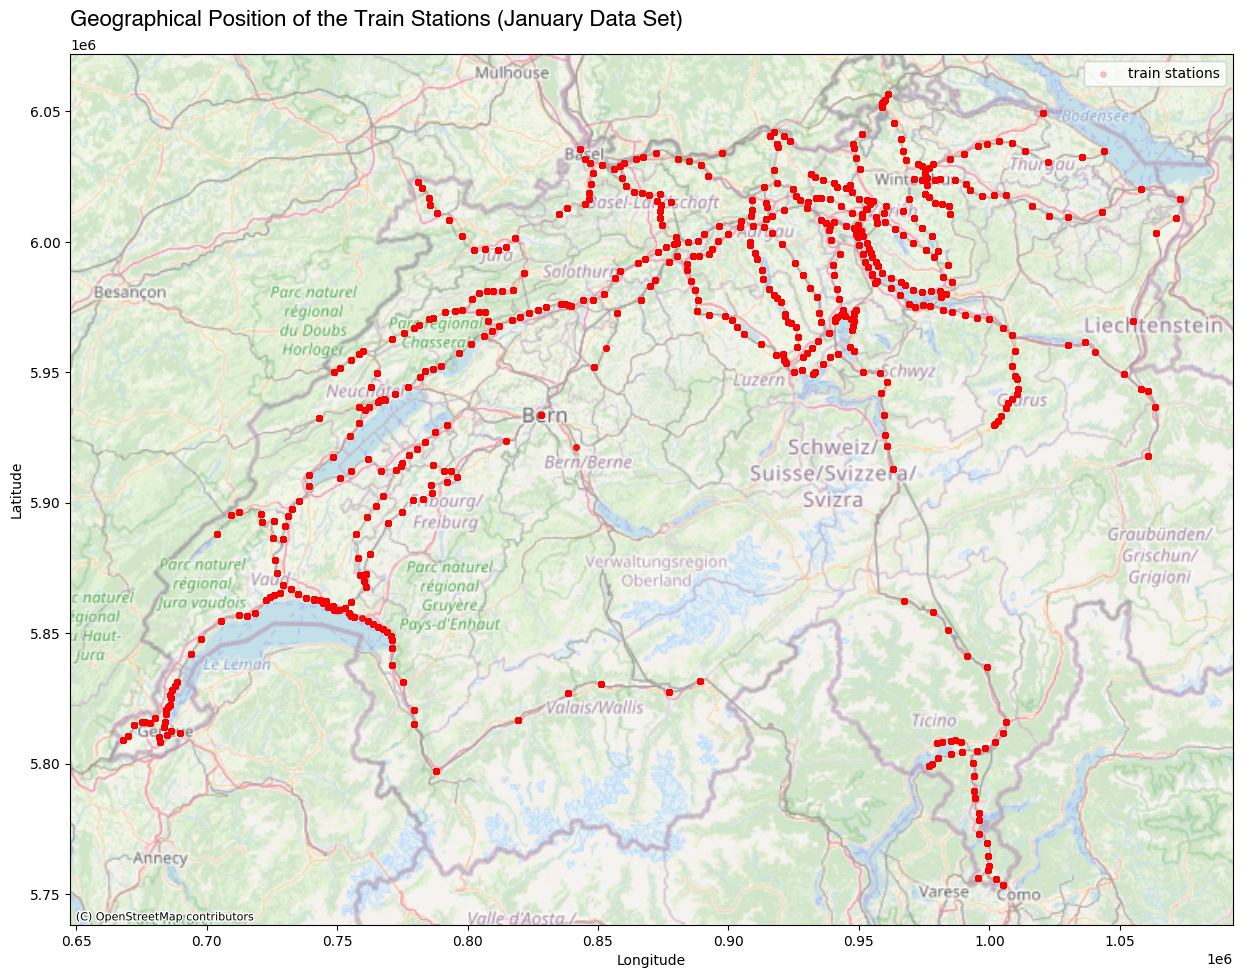

In [31]:
import contextily as ctx # A package that allows you to easily add basemaps to your plots.
import geopandas as gpd # A package that extends the popular pandas library to allow spatial operations on geometric types.
import pandas as pd

# Convert the DataFrame to a GeoDataFrame using GeoPandas
gdf = gpd.GeoDataFrame(
    df_jan, 
    geometry=gpd.points_from_xy(df_jan["longitude"], df_jan["latitude"]),
    crs="EPSG:4326"  # WGS 84, crs="EPSG:4326": Sets the coordinate reference system (CRS) of the data to WGS84, the standard for latitude and longitude coordinates.
)

# Reproject to Web Mercator 
gdf = gdf.to_crs(epsg=3857) # EPSG 3857 is the Web Mercator projection. It is the standard for flat web maps.

# Plotting
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(ax=ax, alpha=0.2, color='red', markersize=15, label="train stations")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.7)

# Customize the axes
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Geographical Position of the Train Stations (January Data Set)",
             fontsize=16, loc='left', pad=20, family = "Helvetica")
plt.legend()

plt.savefig("../../images/geographical_position_january_data_set.png", dpi = 1000)

plt.show()

As one can see on this map, we clearly spot some very dense spots, such as Lake Geneva riviera or the Zürich region. This first image points toward another interesting question: "If a train station is heavily connected to the network, should we expect more delay on average?

#### Network Density & Mean Delay

I attempt to address the question raised above. Is there a positive correlation between the level of connectivity of a station and the mean delay at this station?

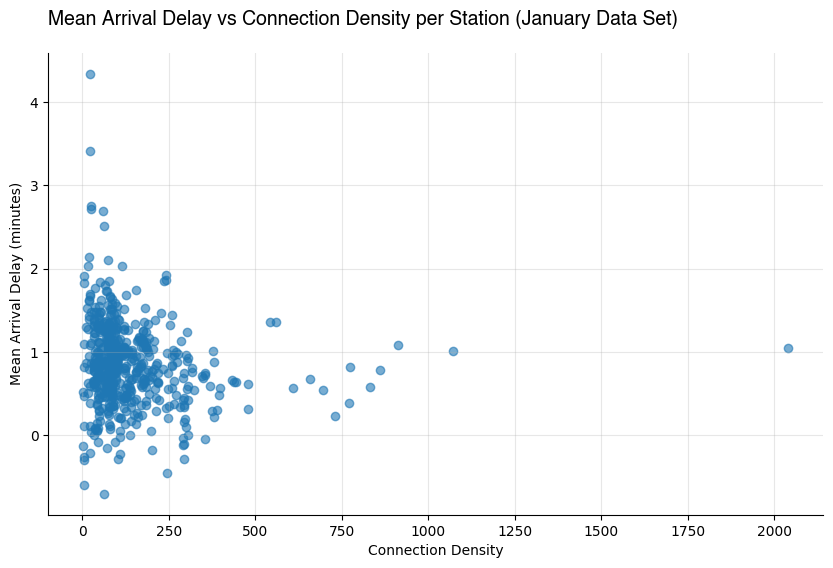

In [45]:
# aggregate by station
station_delay = (
    df_jan.groupby('stop_name')[['arrival_delay_minutes', 'connection_density']]
          .mean()
          .reset_index()
)

# scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(station_delay['connection_density'], station_delay['arrival_delay_minutes'], alpha=0.6)

# aesthetics
ax.set_xlabel('Connection Density')
ax.set_ylabel('Mean Arrival Delay (minutes)')
ax.set_title('Mean Arrival Delay vs Connection Density per Station (January Data Set)',
             loc ='left', pad=20, fontsize=14, family='Helvetica')
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("../../images/delay_vs_connection_density_january_data_set.png", dpi=500)
plt.show()


It seems that the connectivity indicator I developed does not convey a significant predictive power. Indeed, the correlation is even slightly negative:

In [47]:
# correlation
correlation = station_delay['connection_density'].corr(station_delay['arrival_delay_minutes'])
print(f"Correlation between Connection Density and Mean Arrival Delay: {correlation:.4f}")

Correlation between Connection Density and Mean Arrival Delay: -0.1251


And the more heavily connected stations are:

Top 10 Most Connected Stations:
              stop_name  connection_density
558           Zürich HB              2040.0
560     Zürich Oerlikon              1071.0
559   Zürich Hardbrücke               912.0
562  Zürich Stadelhofen               862.0
361               Olten               831.0
532          Winterthur               774.0
263            Lausanne               771.0
175              Genève               730.0
393           Renens VD               695.0
547                 Zug               658.0


/var/folders/7v/_v_y1jpx0rl056gg5rkjsw4r0000gn/T/ipykernel_37098/2887228588.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


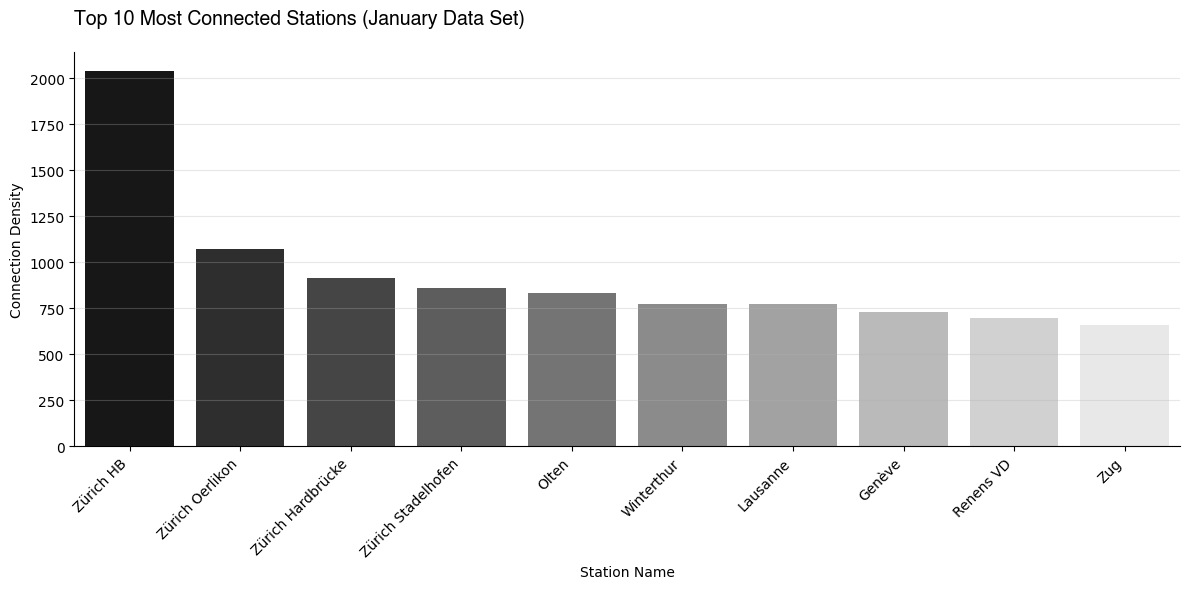

In [52]:
# connected stations
most_connected_stations = station_delay.sort_values(by='connection_density', ascending=False).head(10)
print("Top 10 Most Connected Stations:")
print(most_connected_stations[['stop_name', 'connection_density']])

# bar plot 
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    data=most_connected_stations,
    x='stop_name',
    y='connection_density',
    palette='grey',
    ax=ax
)
# aesthetics
ax.set_xlabel('Station Name')
ax.set_ylabel('Connection Density')
ax.set_title('Top 10 Most Connected Stations (January Data Set)',
             loc='left', pad=20, fontsize=14, family='Helvetica')
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("../../images/top_10_most_connected_stations_january_data_set.png", dpi
=500)
plt.show()

#### Correlation of Features with Target

To continue further our EDA, let us explore how the features we have correlate with the numerical target variable for delay:

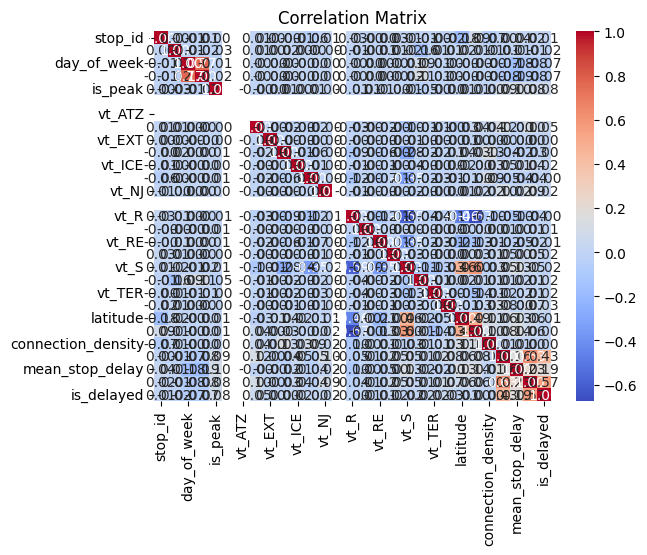

In [ ]:
# correlation of target with the features

In [59]:
# target
target = 'arrival_delay_minutes'

# inspect correlation of target with the features
correlations = df_jan[feature_columns + [target]].corr()[target].sort_values(ascending=False)
print("CORRELATION OF TARGET WITH THE FEATURES")
print(correlations)

CORRELATION OF TARGET WITH THE FEATURES
arrival_delay_minutes    1.000000
running_trip_delay       0.632488
mean_stop_delay          0.230560
vt_EC                    0.100333
vt_NJ                    0.094990
is_peak                  0.080534
vt_TGV                   0.073474
longitude                0.064725
latitude                 0.057949
vt_RJX                   0.046972
vt_S                     0.045465
vt_ICE                   0.043082
stop_id                  0.017213
vt_TER                   0.013887
vt_SN                    0.011257
vt_RB                    0.008147
connection_density       0.003585
vt_EXT                   0.000323
hour_of_day             -0.009911
vt_RE                   -0.020689
vt_IC                   -0.030388
vt_IR                   -0.039610
vt_R                    -0.043297
day_of_week             -0.080507
is_weekend              -0.084140
vt_AG                         NaN
vt_ATZ                        NaN
vt_PE                         NaN
Name: ar

Here, the reader must be careful with is interepretation and keep in mind that the correlation coefficient $\rho$ only measure linear relationships. Hence, we might have non-linear relationships in the data that play an important role in tree-based models like our random forest.

However, as expected, the congestion features are the ones who cary the highest linear predictive power, especially **running_trip_delay**. If a train is accumulating delay, it is highly likely that it will be delayed at the next station. This is what we are observing.